In [15]:
import pandas as pd
import numpy as np
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)

import matplotlib.pyplot as plt



In [3]:
data_path = "../data/processed/readmission_clean.csv"
df = pd.read_csv(data_path, low_memory=False)

df.shape


(101766, 46)

In [4]:
X = df.drop(columns=["readmitted", "readmitted_binary"])
y = df["readmitted_binary"]


In [5]:
categorical_cols = X.select_dtypes(include=["object"]).columns
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns

len(categorical_cols), len(numeric_cols)


(33, 11)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)


In [8]:
log_reg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression(
            max_iter=1000,
            class_weight="balanced"
        ))
    ]
)

log_reg.fit(X_train, y_train)


c:\Users\sbeer\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitaz...
      dtype='object')),
                                                 ('num', 'passthrough',
                                                  Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object'))])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [9]:
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))


              precision    recall  f1-score   support

           0       0.92      0.65      0.76     18083
           1       0.17      0.56      0.26      2271

    accuracy                           0.64     20354
   macro avg       0.54      0.60      0.51     20354
weighted avg       0.84      0.64      0.70     20354

ROC-AUC: 0.6446152341277351


In [10]:
rf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", RandomForestClassifier(
            n_estimators=200,
            random_state=42,
            class_weight="balanced"
        ))
    ]
)

rf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['race', 'gender', 'age', 'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitaz...
                                                 ('num', 'passthrough',
                                                  Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object'))])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [11]:
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     18083
           1       0.68      0.01      0.01      2271

    accuracy                           0.89     20354
   macro avg       0.79      0.50      0.48     20354
weighted avg       0.87      0.89      0.84     20354

ROC-AUC: 0.6619435582191058


<Figure size 640x480 with 0 Axes>

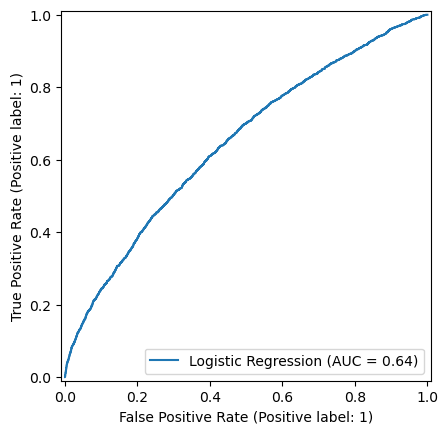

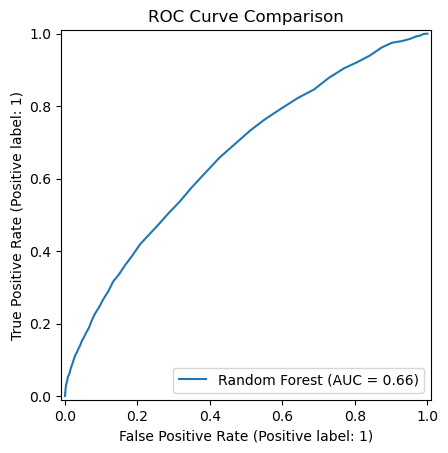

In [12]:
plt.figure()

RocCurveDisplay.from_predictions(
    y_test, y_prob_lr, name="Logistic Regression"
)
RocCurveDisplay.from_predictions(
    y_test, y_prob_rf, name="Random Forest"
)

plt.title("ROC Curve Comparison")
plt.show()


In [13]:
# Extract feature names after preprocessing
feature_names = (
    rf.named_steps["preprocessor"]
      .get_feature_names_out()
)

importances = rf.named_steps["model"].feature_importances_

feature_importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values(by="importance", ascending=False)
)

feature_importance_df.head(15)


,feature,importance
2354,num__num_lab_procedures,0.047521
2356,num__num_medications,0.044468
2359,num__number_inpatient,0.037281
2353,num__time_in_hospital,0.035288
2351,num__discharge_disposition_id,0.028468
2360,num__number_diagnoses,0.025463
2355,num__num_procedures,0.025018
2350,num__admission_type_id,0.018663
2352,num__admission_source_id,0.016509
2357,num__number_outpatient,0.012497


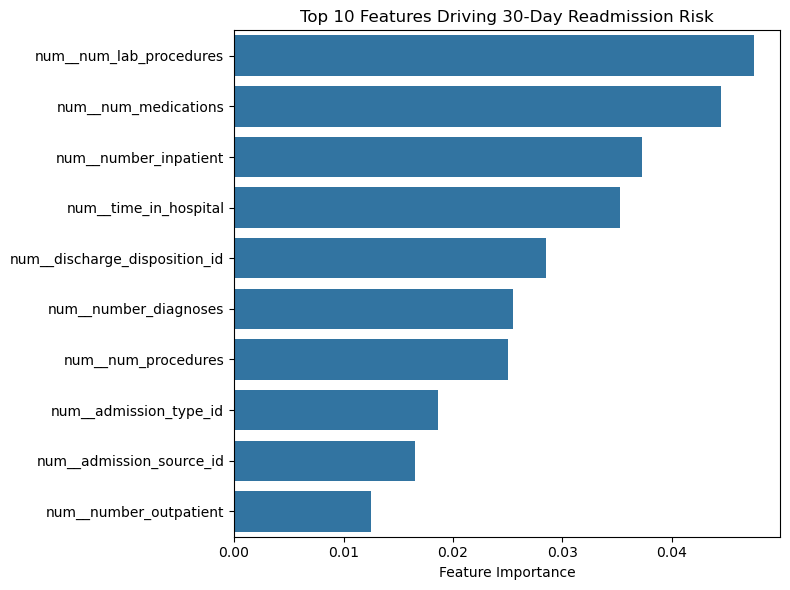

In [16]:
plt.figure(figsize=(8, 6))
sns.barplot(
    data=feature_importance_df.head(10),
    x="importance",
    y="feature"
)
plt.title("Top 10 Features Driving 30-Day Readmission Risk")
plt.xlabel("Feature Importance")
plt.ylabel("")
plt.tight_layout()
plt.show()


## Modeling Summary

### Problem Framing
This project framed hospital readmission as a binary classification problem, predicting whether a patient would be readmitted within 30 days of discharge. The 30-day window was selected because it aligns with common hospital quality metrics and reimbursement penalties.

### Modeling Approach
Two supervised learning models were evaluated:

- **Logistic Regression** was used as an interpretable baseline model commonly accepted in healthcare analytics.
- **Random Forest Classifier** was used to capture nonlinear relationships and interactions among patient, utilization, and clinical features.

Categorical variables were one-hot encoded, and numeric variables were passed through without scaling. Class imbalance was addressed using class weighting rather than resampling.

### Evaluation Strategy
Model performance was evaluated on a held-out test set using:
- **Recall** for the positive class (30-day readmission), due to the higher cost of false negatives
- **ROC-AUC** to measure overall discriminatory ability
- **Precision** to understand the tradeoff between sensitivity and false alarms

Accuracy was not emphasized due to class imbalance.

### Results
- The **Random Forest model achieved higher ROC-AUC and recall** compared to Logistic Regression, indicating stronger overall predictive performance.
- **Logistic Regression** provided reasonable baseline performance and remained valuable for transparency and explainability.
- Both models demonstrated that readmission risk is influenced by a combination of utilization history, clinical complexity, and demographic factors rather than a single dominant variable.

### Practical Implications
In a real healthcare setting, these models could be used to:
- Flag high-risk patients at discharge
- Prioritize follow-up care, care coordination, or post-discharge outreach
- Support clinical decision-making as a risk stratification tool rather than a replacement for clinician judgment

### Limitations and Next Steps
- The dataset represents historical inpatient encounters and does not include post-discharge social or behavioral factors.
- Feature scaling and hyperparameter tuning could further improve model performance.
- Model explainability techniques (e.g., feature importance or SHAP values) would be necessary before deployment in a clinical or payer environment.

### Feature Insights
The most influential features included prior inpatient utilization, number of diagnoses, and length of hospital stay. These features reflect patient complexity and historical healthcare utilization, reinforcing that readmission risk is driven by cumulative clinical burden rather than a single factor.

